## Structured data prediction using Cloud ML Engine 

This notebook illustrates:

1. Exploring a BigQuery dataset using Datalab
2. Creating datasets for Machine Learning using Dataflow
3. Creating a model using the high-level Estimator API 
4. Training on Cloud ML Engine
5. Deploying the model
6. Predicting with the model

### Housekeeping 

In [1]:
BUCKET = 'ksalama-gcs-cloudml'
PROJECT = 'ksalama-gcp-playground'
REGION = 'europe-west1'

In [2]:
import os
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION

In [3]:
gcs_data_dir = 'gs://{0}/data/babyweight/'.format(BUCKET)
gcs_model_dir = 'gs://{0}/ml-models/babyweight/'.format(BUCKET)

In [4]:
%%bash

gsutil -m rm -rf gs://ksalama-gcs-cloudml/ml-models/babyweight/*
gsutil -m rm -rf gs://ksalama-gcs-cloudml/data/babyweight/*

CommandException: 1 files/objects could not be removed.
Removing gs://ksalama-gcs-cloudml/data/babyweight/eval.csv-00000-of-00002#1506537239547176...
Removing gs://ksalama-gcs-cloudml/data/babyweight/eval.csv-00001-of-00002#1506537239469603...
Removing gs://ksalama-gcs-cloudml/data/babyweight/train.csv-00000-of-00003#1506537331152133...
Removing gs://ksalama-gcs-cloudml/data/babyweight/train.csv-00001-of-00003#1506537331172788...
Removing gs://ksalama-gcs-cloudml/data/babyweight/train.csv-00002-of-00003#1506537331033168...
Removing gs://ksalama-gcs-cloudml/data/babyweight//live_demo/eval.csv-00000-of-00001#1506538723754493...
Removing gs://ksalama-gcs-cloudml/data/babyweight//live_demo/tmp/staging/preprocess-babyweight-data-170927-185236.1506538357.055425/dataflow_python_sdk.tar#1506538360468799...
Removing gs://ksalama-gcs-cloudml/data/babyweight//live_demo/train.csv-00000-of-00001#1506538711750791...
Removing gs://ksalama-gcs-cloudml/data/babyweight/live_demo/#1506538369929429...
Rem

## Query data in BigQuery

The data is natality data (record of births in the US). My goal is to predict the baby's weight given a number of factors about the pregnancy and the baby's mother.  Later, we will want to split the data into training and eval datasets. The hash of the year-month will be used for that.

In [1]:
%%bq query

SELECT
  mother_race,
  AVG(weight_pounds) avg_weight,
  COUNT(weight_pounds) instance_Count
FROM
  `publicdata.samples.natality`
WHERE 
    year > 2000
AND weight_pounds > 0
AND mother_age > 0
AND plurality > 0
AND gestation_weeks > 0
AND month > 0
AND mother_race is not null
GROUP BY
  mother_race
ORDER BY
  avg_weight DESC

mother_race,avg_weight,instance_Count
38,7.72896198835,9276
3,7.34278681713,286256
1,7.33805926645,17948909
28,7.27510592201,62852
58,7.26597115586,2271
6,7.21173577677,19684
4,7.21122829707,201226
68,7.07605662112,117340
9,7.05189606183,134789
48,7.02306331938,80092


### Fetch data from BigQuery as a pandas dataframe

In [6]:
step_size = 100000

In [7]:
%sql --module query 

SELECT
  weight_pounds,
  is_male,
  mother_age,
  mother_race,
  plurality,
  gestation_weeks,
  mother_married,
  ever_born,
  cigarette_use,
  alcohol_use
FROM
  `publicdata.samples.natality`
WHERE 
    year > 2000
AND weight_pounds > 0
AND mother_age > 0
AND plurality > 0
AND gestation_weeks > 0
AND month > 0
AND
  MOD(ABS(FARM_FINGERPRINT(CONCAT(CAST(YEAR AS STRING), CAST(month AS STRING)))), 2) = 0
LIMIT $STEP_SIZE

In [8]:
import datalab.bigquery as bq
import sys
data = bq.Query(query, STEP_SIZE = step_size).to_dataframe(dialect='standard')
print('Row count:{}'.format(len(data)))
data.head(5)

Row count:100000


,weight_pounds,is_male,mother_age,mother_race,plurality,gestation_weeks,mother_married,ever_born,cigarette_use,alcohol_use
0,6.874013,False,13,None,1,40,False,1.0,None,None
1,7.859480,True,13,None,1,39,False,1.0,None,None
2,6.437498,False,13,None,1,37,False,1.0,None,None
3,1.999593,True,13,None,1,28,False,1.0,None,None
4,4.437905,True,13,None,1,34,False,1.0,None,None


In [9]:
data.describe()

,weight_pounds,mother_age,plurality,gestation_weeks,ever_born
count,100000.000000,100000.000000,100000.00000,100000.000000,99620.000000
mean,7.238451,27.378180,1.03463,38.625980,2.067256
std,1.321511,6.178278,0.19373,2.562416,1.240264
min,0.500449,13.000000,1.00000,17.000000,1.000000
25%,6.563162,22.000000,1.00000,38.000000,1.000000
50%,7.312733,27.000000,1.00000,39.000000,2.000000
75%,8.062305,32.000000,1.00000,40.000000,3.000000
max,14.374139,50.000000,5.00000,47.000000,18.000000


### Explore & Visualise

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

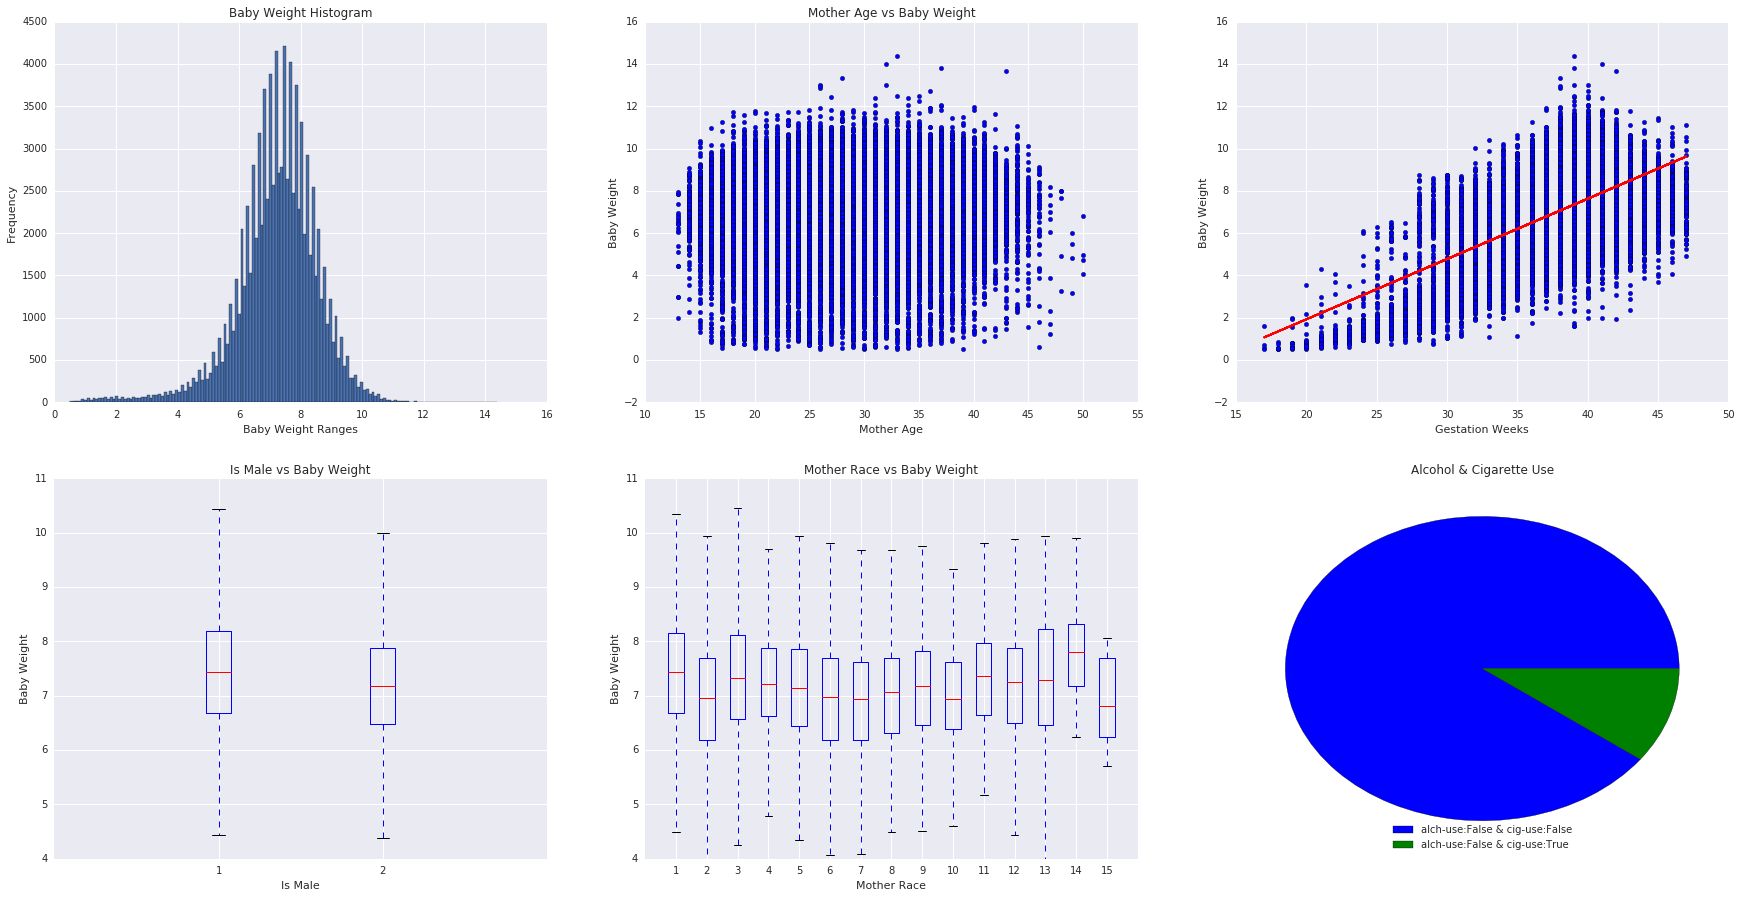

In [11]:
plt.close('all')
#plt.figure(figsize=(45, 25))
plt.figure(figsize=(30, 15))

# Baby Weight Distribution
plt.subplot(2,3,1)
plt.title("Baby Weight Histogram")
plt.hist(data.weight_pounds, bins=150)
#plt.axis([0, 50, 0, 3500])
plt.xlabel("Baby Weight Ranges")
plt.ylabel("Frequency")
# ---------------------------

# Mother Age vs Baby Weight
plt.subplot(2,3,2)
plt.title("Mother Age vs Baby Weight")
plt.scatter(data.mother_age,data.weight_pounds)
plt.xlabel("Mother Age")
plt.ylabel("Baby Weight")
# ---------------------------

# Gestation Weeks vs Baby Weight
plt.subplot(2,3,3)
fit = np.polyfit(data.gestation_weeks,data.weight_pounds, deg=1)
plt.plot(data.gestation_weeks, fit[0] * data.gestation_weeks + fit[1], color='red')
plt.scatter(data.gestation_weeks, data.weight_pounds)
plt.xlabel("Gestation Weeks")
plt.ylabel("Baby Weight")

#---------------------------

# Is Male vs Baby Weight Boxplot
plt.subplot(2,3,4)
plt.title("Is Male vs Baby Weight")

is_male_values = list(data.is_male.value_counts().index.values)
is_male_data = []
for i in is_male_values:
    is_male_data = is_male_data + [data.weight_pounds[data.is_male == i].values]

plt.boxplot(is_male_data)
plt.axis([0, 3, 4, 11])
plt.xlabel("Is Male")
plt.ylabel("Baby Weight")
# ---------------------------

# Mother Race vs Baby Weight Boxplot
plt.subplot(2,3,5)
plt.title("Mother Race vs Baby Weight")

race_values = list(data.mother_race.value_counts().index.values)
race_data = []
for i in race_values:
    race_data = race_data + [data.weight_pounds[data.mother_race == i].values]

plt.boxplot(race_data)
plt.axis([0, 16, 4, 11])
plt.xlabel("Mother Race")
plt.ylabel("Baby Weight")

# # ---------------------------

plt.subplot(2,3,6)
plt.title("Alcohol & Cigarette Use")

alch_use_values = list(data.alcohol_use.value_counts().index.values)
cig_use_values = list(data.cigarette_use.value_counts().index.values)

use_data = []
labels = []

for i in alch_use_values:
    for j in cig_use_values:
        labels = labels + ['alch-use:{} & cig-use:{}'.format(i,j)]
        condition = (data.alcohol_use == i) & (data.cigarette_use == j)
        values = data.weight_pounds[condition].values
        if (len(values) > 0):
            use_data = use_data + [len(values)]

plt.pie(use_data)
plt.legend(labels, loc="lower center")

plt.show()

### Average Weight as a Baseline Estimator

In [ ]:
import numpy as np

avg_weight = data.weight_pounds.mean()
print("Average Weight: {}".format(round(avg_weight,3)))
rmse = np.sqrt(data.weight_pounds.map(lambda value: (value-avg_weight)**2).mean())
print("RMSE: {}".format(round(rmse,3)))

### Create ML dataset using Dataflow

Let's use Cloud Dataflow to read in the BigQuery data and write it out as CSV files. 


In [ ]:
import apache_beam as beam
import datetime

dataset_size = 1000000
train_size = dataset_size * 0.7
eval_size = dataset_size * 0.3

out_dir = gcs_data_dir + "live_demo"

print(out_dir)

def to_csv(rowdict):
    # pull columns from BQ and create a line
    import hashlib
    import copy
    CSV_COLUMNS = 'weight_pounds,is_male,mother_age,mother_race,plurality,gestation_weeks,mother_married,cigarette_use,alcohol_use'.split(',')
    # modify opaque numeric race code into human-readable data
    races = dict(zip([1,2,3,4,5,6,7,18,28,39,48],
                     ['White', 'Black', 'American Indian', 'Chinese', 
                      'Japanese', 'Hawaiian', 'Filipino',
                      'Asian Indian', 'Korean', 'Samaon', 'Vietnamese']))
    result = copy.deepcopy(rowdict)
    if 'mother_race' in rowdict and rowdict['mother_race'] in races:
        result['mother_race'] = races[rowdict['mother_race']]
    else:
        result['mother_race'] = 'Unknown'
    
    data = ','.join([str(result[k]) if k in result else 'None' for k in CSV_COLUMNS])
    key = hashlib.sha224(data).hexdigest()  # hash the columns to form a key
    return str('{},{}'.format(data, key))
  
def run_pipeline():
    
    job_name = 'preprocess-babyweight-data' + '-' + datetime.datetime.now().strftime('%y%m%d-%H%M%S')
    print 'Launching Dataflow job {} ... hang on'.format(job_name)

    options = {
        'staging_location': os.path.join(out_dir, 'tmp', 'staging'),
        'temp_location': os.path.join(out_dir, 'tmp'),
        'job_name': job_name,
        'project': PROJECT,
        'teardown_policy': 'TEARDOWN_ALWAYS',
        'no_save_main_session': True
    }
  
    query = """
        SELECT
          weight_pounds,
          is_male,
          mother_age,
          mother_race,
          plurality,
          gestation_weeks,
          mother_married,
          ever_born,
          cigarette_use,
          alcohol_use,
          FARM_FINGERPRINT(CONCAT(CAST(YEAR AS STRING), CAST(month AS STRING))) AS hashmonth
        FROM
          publicdata.samples.natality
        WHERE year > 2000
        AND weight_pounds > 0
        AND mother_age > 0
        AND plurality > 0
        AND gestation_weeks > 0
        AND month > 0
    """
  
    opts = beam.pipeline.PipelineOptions(flags=[], **options)
    RUNNER = 'DataflowRunner'
  
    p = beam.Pipeline(RUNNER, options=opts)
    
    for step in ['train', 'eval']:
        if step == 'train':
            source_query = 'SELECT * FROM ({}) WHERE MOD(hashmonth,4) < 3 LIMIT {}'.format(query,int(train_size))
        else:
            source_query = 'SELECT * FROM ({}) WHERE MOD(hashmonth,4) = 3 LIMIT {}'.format(query,int(eval_size))

        (p 
           | '{} - Read from BigQuery'.format(step) >> beam.io.Read(beam.io.BigQuerySource(query=source_query, use_standard_sql=True))
           | '{} - Process to CSV'.format(step) >> beam.Map(to_csv)
           | '{} - Write to GCS '.format(step) >> beam.io.Write(beam.io.WriteToText(os.path.join(out_dir, '{}.csv'.format(step))))
        )
    
   
    job = p.run()

## Run Dataflow Preprocessing Pipeline

In [ ]:
run_pipeline()

In [ ]:
%%bash

gsutil cp gs://ksalama-gcs-cloudml/data/babyweight/train.csv-00000-* data/babyweight
gsutil cp gs://ksalama-gcs-cloudml/data/babyweight/eval.csv-00000-* data/babyweight
ls data/babyweight
head -3 data/babyweight/train.csv-00000-of-00003
wc -l data/babyweight/train.csv-00000-of-00003
wc -l data/babyweight/eval.csv-00000-of-00002

## Create TensorFlow DNN Regressor using Estimator API

In [ ]:
import tensorflow as tf
print(tf.__version__)

### 1 - Define Metadata &  Input Function

In [ ]:
HEADER = 'weight_pounds,is_male,mother_age,mother_race,plurality,gestation_weeks,mother_married,cigarette_use,alcohol_use,key'.split(',')
TARGET_NAME = 'weight_pounds'
KEY_COLUMN = 'key'
DEFAULTS = [[0.0], ['null'], [0.0], ['null'], [0.0], [0.0], ['null'], ['null'], ['null'], ['nokey']]

def csv_input_fn(filename, num_epochs=None, batch_size=512):
    
    input_file_names = tf.train.match_filenames_once(filename)
 
    filename_queue = tf.train.string_input_producer(
        input_file_names, num_epochs=num_epochs, shuffle=False)
    
    reader = tf.TextLineReader()
    _, value = reader.read_up_to(filename_queue, num_records=batch_size)

    value_column = tf.expand_dims(value, -1)
    columns = tf.decode_csv(value_column, record_defaults=DEFAULTS)
    
    features = dict(zip(HEADER, columns))
    
    features.pop(KEY_COLUMN)
    
    target = features.pop(TARGET_NAME)    
    
    return features, target

### 2 - Create Feature Columns

In [ ]:
def get_deep_and_wide_columns():
    races = ['White', 'Black', 'American Indian', 'Chinese', 
               'Japanese', 'Hawaiian', 'Filipino', 'Unknown',
               'Asian Indian', 'Korean', 'Samaon', 'Vietnamese']
    
    is_male,mother_age,mother_race,plurality,gestation_weeks,mother_married,cigarette_use,alcohol_use = [ \
        tf.feature_column.categorical_column_with_vocabulary_list('is_male', ['True', 'False']),
        tf.feature_column.numeric_column('mother_age'),
        tf.feature_column.categorical_column_with_vocabulary_list('mother_race', races),
        tf.feature_column.numeric_column('plurality'),
        tf.feature_column.numeric_column('gestation_weeks'),
        tf.feature_column.categorical_column_with_vocabulary_list('mother_married', ['True', 'False']),
        tf.feature_column.categorical_column_with_vocabulary_list('cigarette_use', ['True', 'False', 'None']),
        tf.feature_column.categorical_column_with_vocabulary_list('alcohol_use', ['True', 'False', 'None'])
        ]

    wide_columns = [is_male, mother_race, plurality, mother_married, cigarette_use, alcohol_use]
    deep_columns = [mother_age, gestation_weeks, tf.feature_column.embedding_column(mother_race, 3)]
    
    return wide_columns, deep_columns

#get_deep_and_wide_columns()

### 3 - Create a Regression Estimator

In [ ]:
def create_DNNLinearCombinedRegressor(run_config,hparams):
  
    wide_columns, deep_columns = get_deep_and_wide_columns()

    dnn_optimizer = tf.train.AdamOptimizer()
    
    estimator = tf.contrib.learn.DNNLinearCombinedRegressor(
                linear_feature_columns = wide_columns,
                dnn_feature_columns = deep_columns,
                dnn_optimizer=dnn_optimizer,
                dnn_hidden_units=hparams.hidden_units,
                config = run_config
                )
    
    return estimator

### 4 - Create Experiment

In [ ]:
train_data_files = "data/babyweight/train.csv-00000-*"
eval_data_files = "data/babyweight/eval.csv-00000-*"

def create_experiment(run_config,hparams):
    
    estimator = create_DNNLinearCombinedRegressor(run_config, hparams)
    
    evaluation_metrics={
    'rmse': tf.contrib.learn.MetricSpec(metric_fn=tf.metrics.root_mean_squared_error)
    }
    
    experiment =  tf.contrib.learn.Experiment(estimator = estimator, 
                                     train_steps = hparams.training_steps,
                                     train_input_fn = lambda: csv_input_fn(train_data_files,
                                                                           num_epochs=hparams.num_epochs,
                                                                           batch_size = hparams.batch_size
                                                                          ), 
                                     eval_input_fn =lambda: csv_input_fn(eval_data_files),
                                     eval_metrics = evaluation_metrics
                                    )
    return experiment

### 5 - Run Local Experiment

In [ ]:
import shutil

# Set params
hparams  = tf.contrib.training.HParams(training_steps=None,
                                       num_epochs = 10,
                                       batch_size = 1000,
                                       hidden_units=[32, 16])


local_model_dir = "trained_models/babyweight_estimator"
shutil.rmtree(local_model_dir, ignore_errors=True)

run_config = tf.contrib.learn.RunConfig(
    model_dir=local_model_dir
)

# Run the experiment
tf.logging.set_verbosity(tf.logging.INFO)
tf.contrib.learn.learn_runner.run(experiment_fn = create_experiment, 
                               run_config = run_config,
                               schedule="train_and_evaluate",
                               hparams=hparams)

## Train the Model on Cloud ML Engine

In [ ]:
%%bash

gsutil -m cp -r gs://ksalama-gcs-cloudml/ml-packages/babyweight ml-packages
ls ml-packages/babyweight

In [ ]:
%%bash

echo "Submitting a Cloud ML Engine job..."

REGION=europe-west1
TIER=BASIC # BASIC | BASIC_GPU | STANDARD_1 | PREMIUM_1
BUCKET=ksalama-gcs-cloudml

MODEL_NAME="babyweight_estimator"

PACKAGE_PATH=ml-packages/babyweight/trainer
TRAIN_FILES=gs://${BUCKET}/data/babyweight/train.csv-00000-of-00003
VALID_FILES=gs://${BUCKET}/data/babyweight/eval.csv-00000-of-00002
MODEL_DIR=gs://${BUCKET}/trained-models/${MODEL_NAME}

#remove model directory, if you don't want to resume training, or if you have changed the model structure
#gsutil -m rm -r ${MODEL_DIR}

CURRENT_DATE=`date +%Y%m%d_%H%M%S`
JOB_NAME=train_${MODEL_NAME}_${CURRENT_DATE}

gcloud ml-engine jobs submit training ${JOB_NAME} \
        --job-dir=${MODEL_DIR} \
        --runtime-version=1.2 \
        --region=${REGION} \
        --scale-tier=${TIER} \
        --module-name=trainer.task \
        --package-path=${PACKAGE_PATH} \
        -- \
        --train-files=${TRAIN_FILES} \
        --num-epochs=100 \
        --train-batch-size=1000 \
        --eval-files=${VALID_FILES} \
        --eval-batch-size=1000 \
        --learning-rate=0.001 \
        --hidden-units="64,0,0" \
        --layer-sizes-scale-factor=0.5 \
        --num-layers=3 \
        --job-dir=${MODEL_DIR}

## Train the Model on Cloud ML Engine + GPUs

In [ ]:
%%bash

echo "Submitting a Cloud ML Engine job..."

REGION=europe-west1
TIER=BASIC_GPU # BASIC | BASIC_GPU | STANDARD_1 | PREMIUM_1
BUCKET=ksalama-gcs-cloudml

MODEL_NAME="babyweight_estimator"

PACKAGE_PATH=ml-packages/babyweight/trainer
TRAIN_FILES=gs://${BUCKET}/data/babyweight/train.csv-00000-of-00003
VALID_FILES=gs://${BUCKET}/data/babyweight/eval.csv-00000-of-00002
MODEL_DIR=gs://${BUCKET}/trained-models/${MODEL_NAME}_${TIER}

#remove model directory, if you don't want to resume training, or if you have changed the model structure
#gsutil -m rm -r ${MODEL_DIR}

CURRENT_DATE=`date +%Y%m%d_%H%M%S`
JOB_NAME=train_${MODEL_NAME}_${TIER}_${CURRENT_DATE}

gcloud ml-engine jobs submit training ${JOB_NAME} \
        --job-dir=${MODEL_DIR} \
        --runtime-version=1.2 \
        --region=${REGION} \
        --scale-tier=${TIER} \
        --module-name=trainer.task \
        --package-path=${PACKAGE_PATH} \
        -- \
        --train-files=${TRAIN_FILES} \
        --num-epochs=10 \
        --train-batch-size=1000 \
        --eval-files=${VALID_FILES} \
        --eval-batch-size=1000 \
        --learning-rate=0.01 \
        --hidden-units="64,0,0" \
        --layer-sizes-scale-factor=0.5 \
        --num-layers=3 \
        --job-dir=${MODEL_DIR}

## Train the Model on Cloud ML Engine + Custom GPUs Cluster

In [ ]:
# %%bash

# echo "Submitting a Cloud ML Engine job..."

# REGION=europe-west1
# TIER=CUSTOM # BASIC | BASIC_GPU | STANDARD_1 | PREMIUM_1
# BUCKET=ksalama-gcs-cloudml

# MODEL_NAME="babyweight_estimator"

# PACKAGE_PATH=ml-packages/babyweight/trainer
# TRAIN_FILES=gs://${BUCKET}/data/babyweight/train.csv-00000-of-00003
# VALID_FILES=gs://${BUCKET}/data/babyweight/eval.csv-00000-of-00002
# MODEL_DIR=gs://${BUCKET}/trained-models/${MODEL_NAME}_${TIER}

# #remove model directory, if you don't want to resume training, or if you have changed the model structure
# #gsutil -m rm -r ${MODEL_DIR}

# CURRENT_DATE=`date +%Y%m%d_%H%M%S`
# JOB_NAME=train_${MODEL_NAME}_${TIER}_${CURRENT_DATE}

# gcloud ml-engine jobs submit training ${JOB_NAME} \
#         --job-dir=${MODEL_DIR} \
#         --runtime-version=1.2 \
#         --region=${REGION} \
#         --module-name=trainer.task \
#         --package-path=${PACKAGE_PATH} \
#         --config=ml-packages/babyweight/custom.yaml \
#         -- \
#         --train-files=${TRAIN_FILES} \
#         --num-epochs=100 \
#         --train-batch-size=1000 \
#         --eval-files=${VALID_FILES} \
#         --eval-batch-size=1000 \
#         --learning-rate=0.001 \
#         --hidden-units="64,0,0" \
#         --layer-sizes-scale-factor=0.5 \
#         --num-layers=3 \
#         --job-dir=${MODEL_DIR}

## Hyper-parameters Tuning on Cloud ML Engine

In [ ]:
%%bash

echo "Submitting a Cloud ML Engine job..."

REGION=europe-west1
BUCKET=ksalama-gcs-cloudml

MODEL_NAME="babyweight_estimator"

PACKAGE_PATH=ml-packages/babyweight/trainer
TRAIN_FILES=gs://${BUCKET}/data/babyweight/train.csv-00000-of-00003
VALID_FILES=gs://${BUCKET}/data/babyweight/eval.csv-00000-of-00002
MODEL_DIR=gs://${BUCKET}/trained-models/${MODEL_NAME}_tune

#remove model directory, if you don't want to resume training, or if you have changed the model structure
#gsutil -m rm -r ${MODEL_DIR}

CURRENT_DATE=`date +%Y%m%d_%H%M%S`
JOB_NAME=tune_${MODEL_NAME}_${CURRENT_DATE}

gcloud ml-engine jobs submit training ${JOB_NAME} \
        --job-dir=${MODEL_DIR} \
        --runtime-version=1.2 \
        --region=${REGION} \
        --module-name=trainer.task \
        --package-path=${PACKAGE_PATH} \
        --config=ml-packages/babyweight/hyperparams.yaml \
        -- \
        --train-files=${TRAIN_FILES} \
        --num-epochs=100 \
        --train-batch-size=1000 \
        --eval-files=${VALID_FILES} \
        --eval-batch-size=1000 \
        --job-dir=${MODEL_DIR}

## Deploy the Model

In [ ]:
%%bash

REGION=europe-west1
BUCKET=ksalama-gcs-cloudml

MODEL_NAME="babyweight_estimator"
MODEL_VERSION="v1"

MODEL_BINARIES=$(gsutil ls gs://${BUCKET}/trained-models/${MODEL_NAME}/export/Servo | tail -1)

gsutil ls ${MODEL_BINARIES}

# delete model version
#gcloud ml-engine versions delete ${MODEL_VERSION} --model=${MODEL_NAME}

# delete model
#gcloud ml-engine models delete ${MODEL_NAME}

# deploy model to GCP
#gcloud ml-engine models create ${MODEL_NAME} --regions=${REGION}

#deploy model version
gcloud ml-engine versions create ${MODEL_VERSION} --model=${MODEL_NAME} --origin=${MODEL_BINARIES} --runtime-version=1.2

echo  ${MODEL_NAME} ${MODEL_VERSION} 
# invoke deployed model to make prediction given new data instances
gcloud ml-engine predict --model=${MODEL_NAME} --version=${MODEL_VERSION} --json-instances=data/babyweight/new-data.json

## Consume the Model as API

In [ ]:
from googleapiclient import discovery
from oauth2client.client import GoogleCredentials

def estimate(project, model_name, version, instances):

    credentials = GoogleCredentials.get_application_default()
    api = discovery.build('ml', 'v1', credentials=credentials,
                discoveryServiceUrl='https://storage.googleapis.com/cloud-ml/discovery/ml_v1_discovery.json')

    request_data = {'instances': instances}

    model_url = 'projects/{}/models/{}/versions/{}'.format(project, model_name, version)
    response = api.projects().predict(body=request_data, name=model_url).execute()

    estimates = list(map(lambda item: round(item["scores"],2)
        ,response["predictions"]
    ))

    return estimates

In [ ]:
PROJECT='ksalama-gcp-playground'
MODEL_NAME='babyweight_estimator'
VERSION='v2'

instances =  [
      {
        'is_male': 'True',
        'mother_age': 26.0,
        'mother_race': 'Asian Indian',
        'plurality': 1.0,
        'gestation_weeks': 39,
        'mother_married': 'True',
        'cigarette_use': 'False',
        'alcohol_use': 'False'
      },
      {
        'is_male': 'False',
        'mother_age': 29.0,
        'mother_race': 'Asian Indian',
        'plurality': 1.0,
        'gestation_weeks': 38,
        'mother_married': 'True',
        'cigarette_use': 'False',
        'alcohol_use': 'False'
      },
      {
        'is_male': 'True',
        'mother_age': 26.0,
        'mother_race': 'White',
        'plurality': 1.0,
        'gestation_weeks': 39,
        'mother_married': 'True',
        'cigarette_use': 'False',
        'alcohol_use': 'False'
      },
      {
        'is_male': 'True',
        'mother_age': 26.0,
        'mother_race': 'White',
        'plurality': 2.0,
        'gestation_weeks': 37,
        'mother_married': 'True',
        'cigarette_use': 'False',
        'alcohol_use': 'False'
      }
  ]

estimates = estimate(instances=instances
                     ,project=PROJECT
                     ,model_name=MODEL_NAME
                     ,version=VERSION)

print(estimates)

### the end ...